## Working GRB
This is the GRB 050128, with 2ms time gap between points.
Works as expected:-

| No of Data Points    | Time Taken |
| -------- | -------   |
|  25      |  9 sec    |
| 120      |  12 sec   |
| 1000     |  4mins    |


## Loading Dependencies

In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

## Loading Data:
This code is mainly to pick up the text file of the specified GRB and convert it into a numpy arrays

In [3]:
def truncate_data(times: np.ndarray, counts: np.ndarray, start: float, stop: float, yerr: np.ndarray = None) -> tuple:
    indices = np.where(np.logical_and(times > start, times < stop))[0]
    if yerr is None:
        return times[indices], counts[indices]
    else:
        return times[indices], counts[indices], yerr[indices]

def get_grb_data_from_segment(
        grb_id: str, grb_binning: str, start_time: float, end_time: float, grb_detector: str = None,
        grb_energy_band: str = "all", grb_label: str = None, bin_size: str = None, **kwargs) -> tuple:
    times, y, yerr = get_all_grb_data(grb_binning=grb_binning, grb_id=grb_id, grb_detector=grb_detector,
                                      grb_label=grb_label, grb_energy_band=grb_energy_band, bin_size=bin_size)
    return truncate_data(times=times, counts=y, start=start_time, stop=end_time, yerr=yerr)


def get_all_grb_data(
        grb_id: str, grb_binning: str, grb_detector: str = None, grb_energy_band: str = "all", grb_label: str = None,
        bin_size: str = None, **kwargs) -> tuple:
    if grb_detector in ["swift", "konus"]:
        data_file = f"data/GRBs/GRB{grb_id}/{grb_binning}_lc_ascii_{grb_detector}.txt"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        if grb_detector == "swift":
            if grb_energy_band == "15-25":
                y = data[:, 1]
                yerr = data[:, 2]
            elif grb_energy_band == "25-50":
                y = data[:, 3]
                yerr = data[:, 4]
            elif grb_energy_band == "50-100":
                y = data[:, 5]
                yerr = data[:, 6]
            elif grb_energy_band == "100-350":
                y = data[:, 7]
                yerr = data[:, 8]
            elif grb_energy_band in ["all", "15-350"]:
                y = data[:, 9]
                yerr = data[:, 10]
            else:
                raise ValueError(f"Energy band {grb_energy_band} not understood")
            return times, y, yerr
        elif grb_detector == "konus":
            y = data[:, 1]
            return times, y, np.sqrt(y)
    elif grb_detector == "batse":
        data_file = f"data/GRBs/GRB{grb_id}/GRB{grb_id}_{grb_energy_band}"
        data = np.loadtxt(data_file)
        times = data[:, 0]
        y = data[:, 1]
        yerr = np.sqrt(y)
        return times, y, yerr
    elif grb_detector.lower() == "asim":
        data_file = f"data/GRBs/GRB{grb_id}/{grb_label}.txt"
        ttes = np.loadtxt(data_file)
        y, bin_edges = np.histogram(ttes, np.arange(ttes[0], ttes[-1], bin_size))
        times = np.array([bin_edges[i] + (bin_edges[i + 1] - bin_edges[i]) / 2 for i in range(len(bin_edges) - 1)])
        yerr = np.sqrt(y)
        return times, y, yerr
    
_GRB_RUN_MODES = dict(select_time=get_grb_data_from_segment,
                      entire_segment=get_all_grb_data)

def get_grb_data(run_mode: str, **kwargs) -> tuple:
    """ Catch all function """
    return _GRB_RUN_MODES[run_mode](**kwargs)

## Labels for our GRB

In [4]:
grb_id = "050128"
grb_label = ""
grb_binning = "64ms"
grb_detector = "swift"
grb_energy_band = "all"

times, y, yerr = get_all_grb_data(
        grb_id = grb_id, grb_binning = grb_binning, grb_detector = grb_detector, 
        grb_energy_band = grb_energy_band, grb_label= grb_label,
        bin_size= None)

print(times.shape, y.shape, yerr.shape)

(9407,) (9407,) (9407,)


#### Plotting the Total Lightcurve
Has a 1000 points

<ErrorbarContainer object of 3 artists>

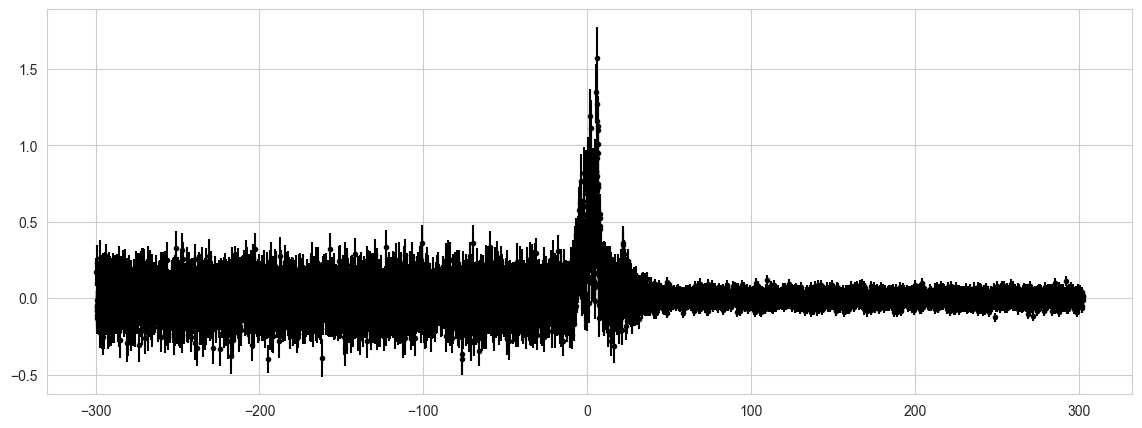

In [6]:
fig, ax = plt.subplots(1,1, figsize = (14,5))
ax.errorbar(times, y, yerr=yerr, fmt=".k", capsize=0, label="data")

## Slicing the GRB
Here We can slice the data by putting the start and end time that we want to use

**Saved as times2, y2, yerr2**

Example from t = -7.75 to t = -7.70

In this demo, file, I have taken all the 1000 points

In [43]:
times2, y2, yerr2 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -10.0, end_time = +10.0, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
times2 = jnp.asarray(times2)
y2 = jnp.asarray(y2)
yerr2 = jnp.asarray(yerr2)
print(times2.shape, y2.shape, yerr2.shape)

(313,) (313,) (313,)


<ErrorbarContainer object of 3 artists>

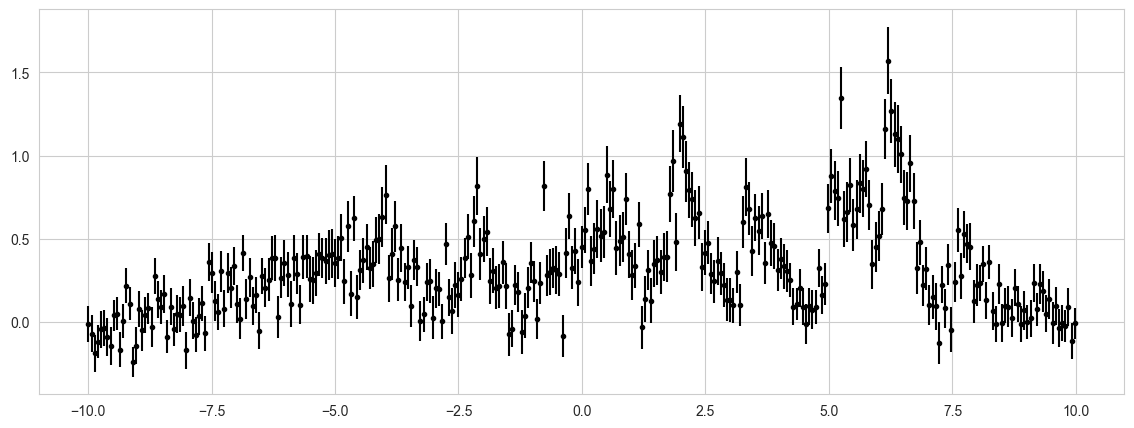

In [10]:
fig, ax = plt.subplots(1,1, figsize = (14,5))
ax.errorbar(times2, y2, yerr=yerr2, fmt=".k", capsize=0, label="data")

## Posterior Sampling

For full data (1000 points) ie. **times, y, yerr**. To use sliced lightcurve, use **times2, y2, yerr2**

In [11]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params, get_kernel, get_mean
tfpd = tfp.distributions
tfpb = tfp.bijectors

from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

In [44]:
y = y2
times = times2
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts = y
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

prior_dict = {
    "A": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high= 2 * span )),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpb.Log()(tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time )),

    "arn": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high = 2 * span )),
    "crn": tfpb.Log()(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f))),
    
    "aqpo": tfpb.Log()(tfpd.Uniform(low = 0.1 * span, high = 2 * span )),
    "cqpo": tfpb.Log()(tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f))),
    "freq": tfpd.Uniform(low = 2 , high = f/4 ),
    # "A": tfpd.Uniform(low = 0.1 * span , high= 2 * span ),
    # "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    # "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time ),

    # "arn": tfpd.Uniform(low = 0.1 * span , high = 2 * span ),
    # "crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
    
    # "aqpo": tfpd.Uniform(low = 0.1 * span, high = 2 * span ),
    # "cqpo": tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f)),
    # "freq": tfpd.Uniform(low = 2 , high = f/4 ),
}

prior_model5 = get_prior(params_list, prior_dict)

# likelihood_model4 = get_likelihood(params_list, kernel_type= "QPO_plus_RN", 
#                                     mean_type = "gaussian", Times = times, 
#                                     counts = counts)
def likelihood_model5(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), "aqpo": jnp.exp(aqpo), "cqpo": jnp.exp(cqpo), "freq": freq}
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}
    # kernel_params = { "arn":arn, "crn":crn, "aqpo":aqpo, "cqpo": cqpo, "freq": freq}
    # mean_params = {"A":A, "t0": t0, "sig":sig}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [45]:
type(np.asarray(times))

numpy.ndarray

In [46]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

from gpmodelling import GPResult
times = np.asarray(times)
Gpresult3 = GPResult(Lightcurve(time = times, counts = counts, dt = times[1]- times[0]))
Gpresult3.sample(prior_model = prior_model5, likelihood_model = likelihood_model5)

# NSmodel = Model(prior_model=prior_model4, log_likelihood=likelihood_model4)
# NSmodel.sanity_check(random.PRNGKey(10), S=100)

# Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=1e4)
# Termination_reason, State = Exact_ns(
#     random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
# )
# Results = Exact_ns.to_results(State, Termination_reason)
print("Simulation Complete")

INFO[2023-08-17 17:41:04,319]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 17:41:04,321]: Checking if light curve is sorted.
INFO[2023-08-17 17:41:04,974]: Sanity check...
INFO[2023-08-17 17:41:04,979]: Sanity check passed


Simulation Complete
Simulation Complete


In [47]:
Gpresult3.print_summary()

--------
Termination Conditions:
Reached max samples
--------
# likelihood evals: 560508
# samples: 10000
# slices: 192000.0
# slices / acceptance: 24.0
# likelihood evals / sample: 56.1
# likelihood evals / slice: 2.8
--------
logZ=23.75 +- 0.19
H=5.6e+18
ESS=389
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: -0.94 +- 0.35 | -1.44 / -0.93 / -0.54 | -0.76 | -0.76
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: -1.49 +- 0.21 | -1.69 / -1.53 / -1.24 | -1.7 | -1.7
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: -1.59 +- 0.12 | -1.69 / -1.62 / -1.41 | -1.68 | -1.68
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: -4.97 +- 0.27 | -5.24 / -5.04 / -4.63 | -5.12 | -5.12
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 0.61 +- 0.16 | 0.42 / 0.63 / 0.79 | 0.63 | 0.63
--------
freq: mean +- std.dev. |

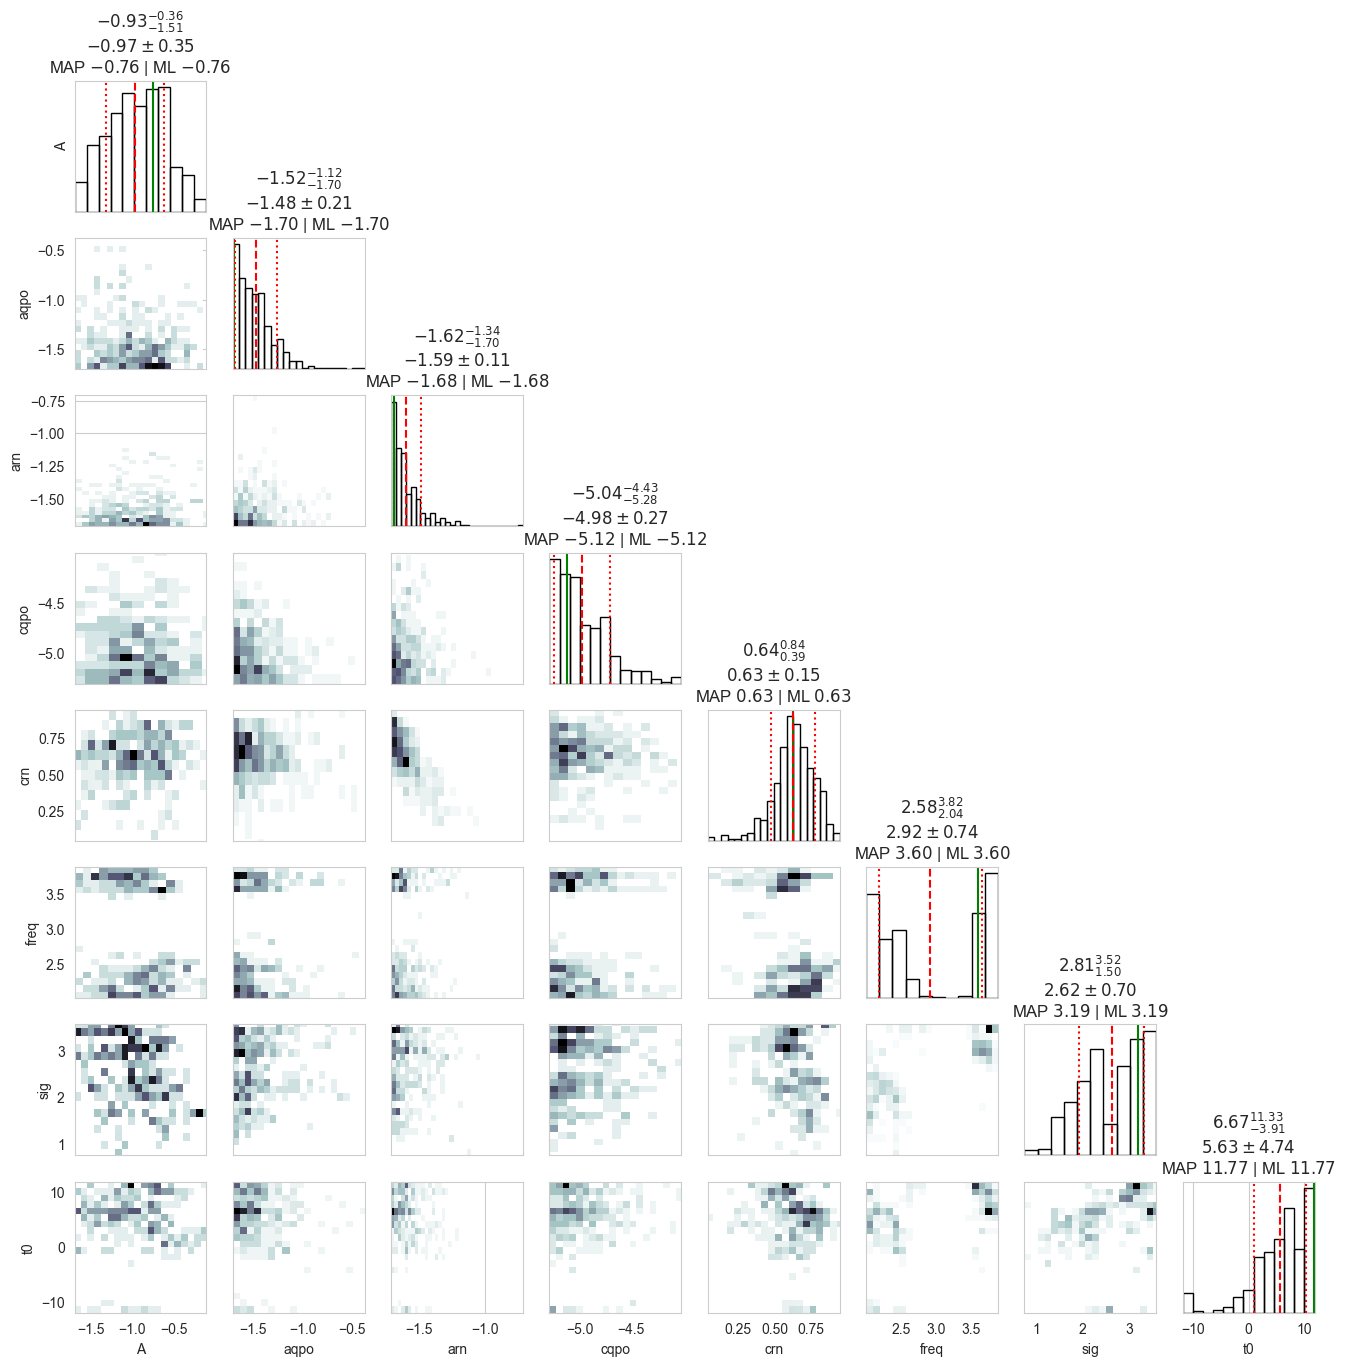

In [27]:
Gpresult3.plot_cornerplot()

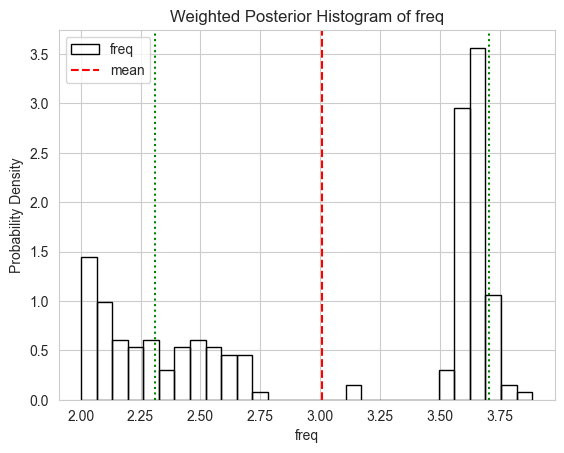

In [20]:
plot = Gpresult3.weighted_posterior_plot("freq")

## Different size time slice

In [30]:
times3, y3, yerr3 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -15.0, end_time = +15.0, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
times3 = jnp.asarray(times3)
y3 = jnp.asarray(y3)
yerr3 = jnp.asarray(yerr3)
print(times3.shape, y3.shape, yerr3.shape)

(469,) (469,) (469,)


<ErrorbarContainer object of 3 artists>

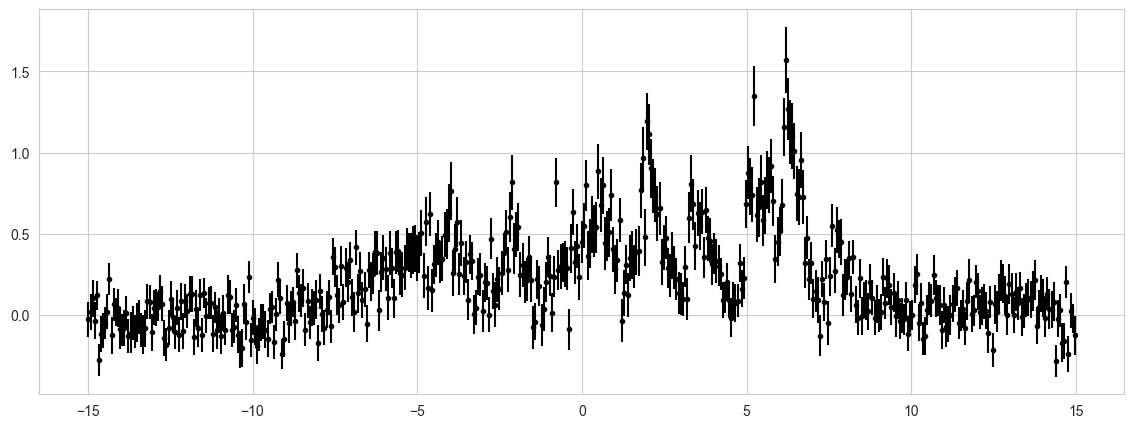

In [31]:
fig, ax = plt.subplots(1,1, figsize = (14,5))
ax.errorbar(times3, y3, yerr=yerr3, fmt=".k", capsize=0, label="data")

In [33]:
y = y3
times = times3
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts = y
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

prior_dict = {
    "A": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high= 2 * span )),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpb.Log()(tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time )),

    "arn": tfpb.Log()(tfpd.Uniform(low = 0.1 * span , high = 2 * span )),
    "crn": tfpb.Log()(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f))),
    
    "aqpo": tfpb.Log()(tfpd.Uniform(low = 0.1 * span, high = 2 * span )),
    "cqpo": tfpb.Log()(tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f))),
    "freq": tfpd.Uniform(low = 2 , high = f/4 ),
}

prior_model5 = get_prior(params_list, prior_dict)

def likelihood_model5(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), "aqpo": jnp.exp(aqpo), "cqpo": jnp.exp(cqpo), "freq": freq}
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [35]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

from gpmodelling import GPResult
times = np.asarray(times)
Gpresult4 = GPResult(Lightcurve(time = times, counts = counts, dt = times[1]- times[0]))
Gpresult4.sample(prior_model = prior_model5, likelihood_model = likelihood_model5)

print("Simulation Complete")

INFO[2023-08-17 17:35:31,397]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 17:35:31,398]: Checking if light curve is sorted.
INFO[2023-08-17 17:35:32,064]: Sanity check...
INFO[2023-08-17 17:35:32,069]: Sanity check passed


Simulation Complete
Simulation Complete


In [36]:
Gpresult4.print_summary()

--------
Termination Conditions:
Reached max samples
--------
# likelihood evals: 599257
# samples: 10000
# slices: 192000.0
# slices / acceptance: 24.0
# likelihood evals / sample: 59.9
# likelihood evals / slice: 3.0
--------
logZ=84.3 +- 0.25
H=1.8e+46
ESS=24
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: -1.05 +- 0.66 | -1.55 / -1.17 / -0.87 | -1.17 | -1.17
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: -1.562 +- 0.094 | -1.655 / -1.582 / -1.441 | -1.484 | -1.484
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: -1.627 +- 0.04 | -1.677 / -1.624 / -1.584 | -1.673 | -1.673
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: -5.56 +- 0.13 | -5.67 / -5.6 / -5.37 | -5.6 | -5.6
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 0.495 +- 0.086 | 0.397 / 0.482 / 0.591 | 0.559 | 0.559
--------
freq: m

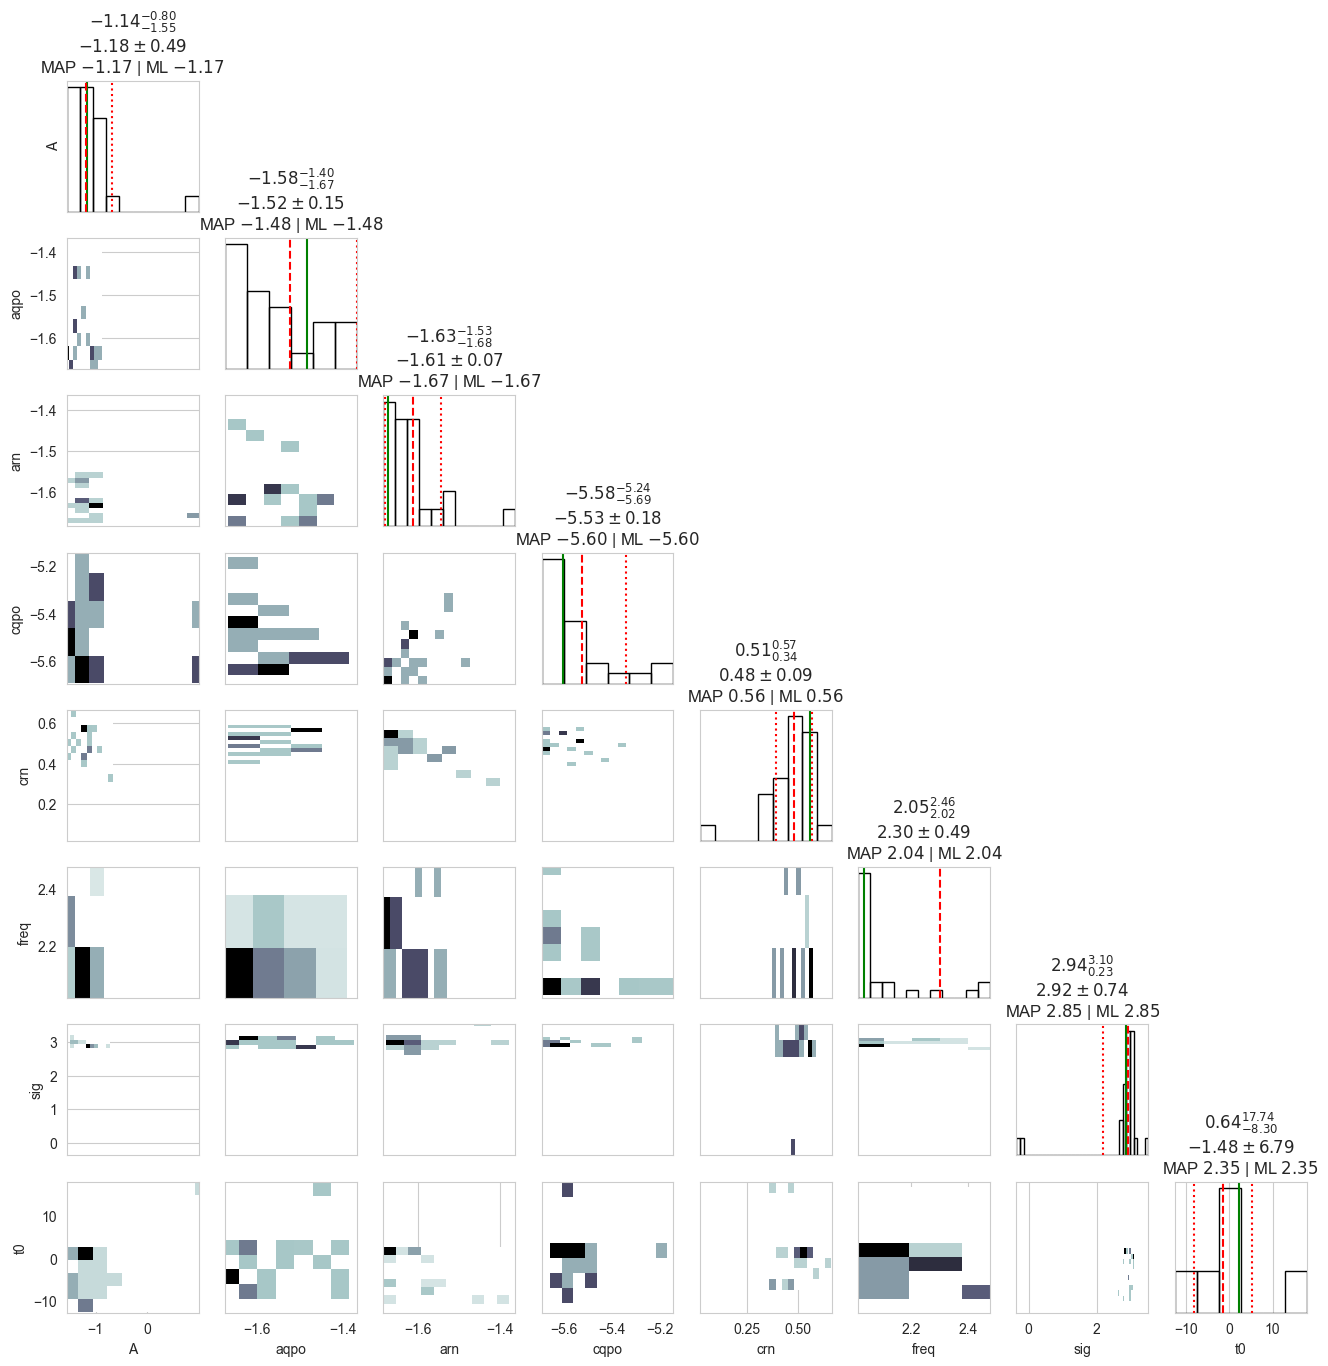

In [38]:
Gpresult4.plot_cornerplot()

WARNING[2023-08-17 17:42:33,196]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


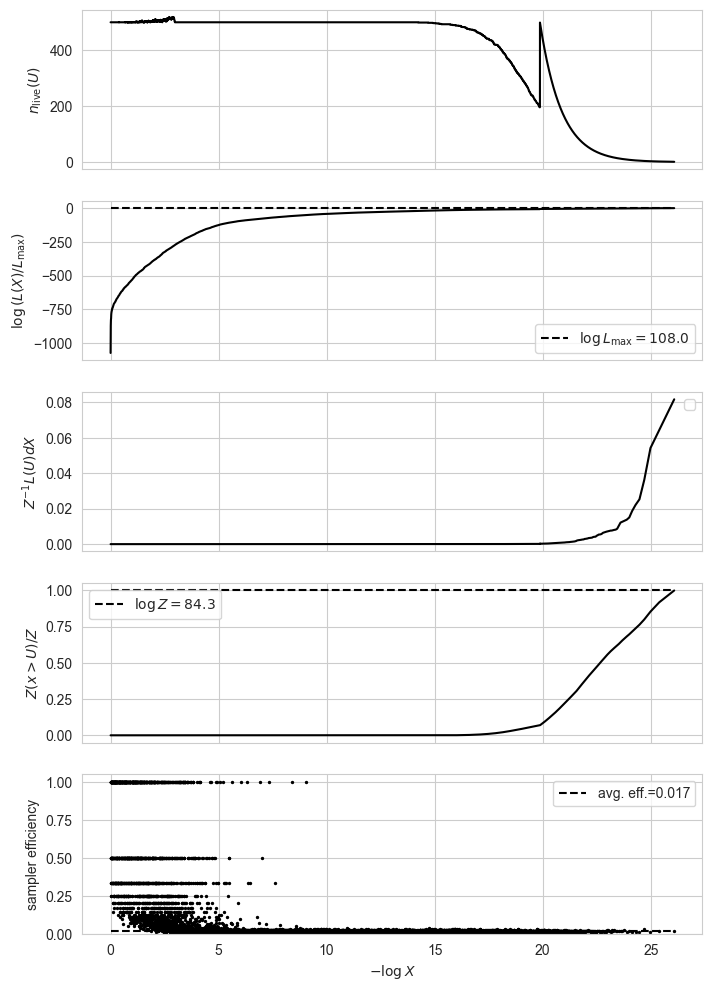

In [49]:
Gpresult4.plot_diagnostics()

WARNING[2023-08-17 17:42:21,473]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


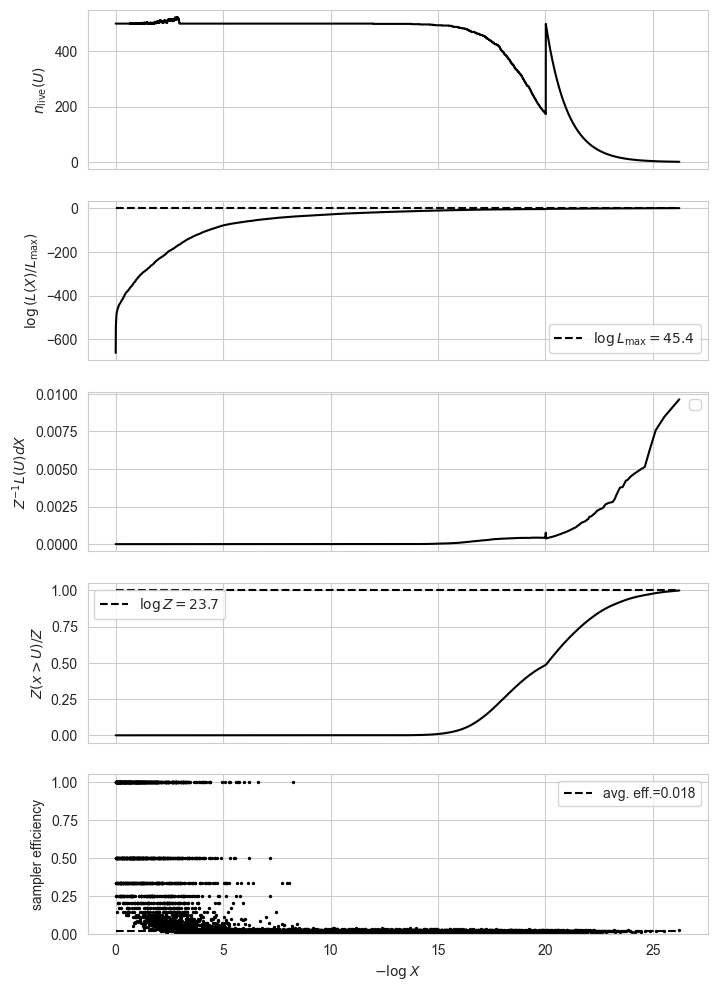

In [48]:
Gpresult3.plot_diagnostics()

# Bigger sample size

In [50]:
times3, y3, yerr3 = get_grb_data_from_segment(
        grb_id = grb_id, grb_binning = grb_binning, start_time = -15.0, end_time = +15.0, grb_detector = grb_detector,
        grb_energy_band = grb_energy_band, grb_label = grb_label, bin_size= None)
times3 = jnp.asarray(times3)
y3 = jnp.asarray(y3)
yerr3 = jnp.asarray(yerr3)
print(times3.shape, y3.shape, yerr3.shape)

(469,) (469,) (469,)


In [53]:
y = y3
times = times3
params_list = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")

counts = y
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

prior_dict = {
    "A": tfpb.Log()(tfpd.Uniform(low = 0.1 * span/10 , high= 2 * span*10 )),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpb.Log()(tfpd.Uniform(low = 0.5 * 1 / f / 10, high = 2 * total_time * 10 )),

    "arn": tfpb.Log()(tfpd.Uniform(low = 0.1 * span / 10 , high = 2 * span * 10 )),
    "crn": tfpb.Log()(tfpd.Uniform(low = jnp.log(1 / total_time/10), high = jnp.log(f*10))),
    
    "aqpo": tfpb.Log()(tfpd.Uniform(low = 0.1 * span / 10, high = 2 * span*10 )),
    "cqpo": tfpb.Log()(tfpd.Uniform(low = 1/10/total_time/10, high = jnp.log(f*10))),
    "freq": tfpd.Uniform(low = 2/10 , high = f/4*10 ),
}

prior_model5 = get_prior(params_list, prior_dict)

def likelihood_model5(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), "aqpo": jnp.exp(aqpo), "cqpo": jnp.exp(cqpo), "freq": freq}
    mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [54]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

from gpmodelling import GPResult
times = np.asarray(times)
Gpresult5 = GPResult(Lightcurve(time = times, counts = counts, dt = times[1]- times[0]))
Gpresult5.sample(prior_model = prior_model5, likelihood_model = likelihood_model5)

print("Simulation Complete")

INFO[2023-08-17 18:05:59,356]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-08-17 18:05:59,356]: Checking if light curve is sorted.
INFO[2023-08-17 18:06:00,042]: Sanity check...
INFO[2023-08-17 18:06:00,049]: Sanity check passed


Simulation Complete
Simulation Complete


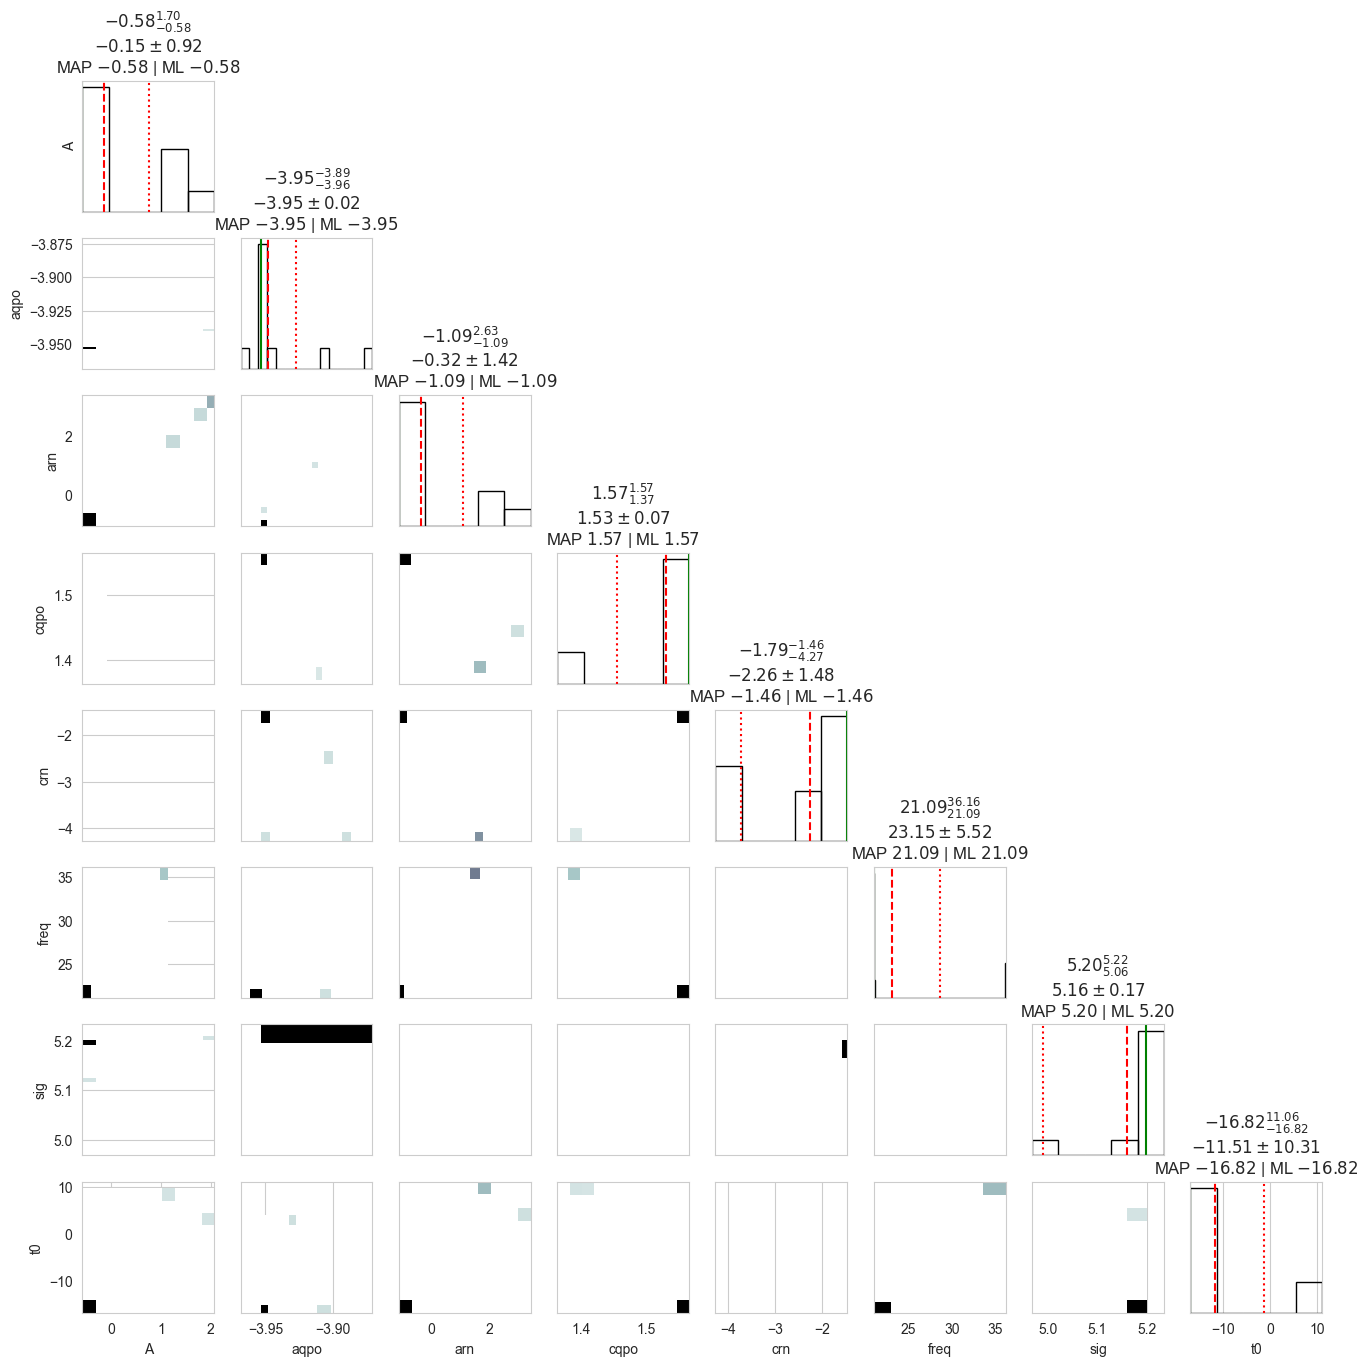

In [55]:
Gpresult5.plot_cornerplot()

In [56]:
Gpresult5.print_summary()

--------
Termination Conditions:
Reached max samples
--------
# likelihood evals: 949814
# samples: 10000
# slices: 192000.0
# slices / acceptance: 24.0
# likelihood evals / sample: 95.0
# likelihood evals / slice: 4.8
--------
logZ=121.33 +- 0.63
H=5.4e+63
ESS=1
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: -0.5793814578498225 +- 1.1e-16 | -0.5793814578498224 / -0.5793814578498224 / -0.5793814578498224 | -0.5793814578498224 | -0.5793814578498224
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: -4.0 +- 0.0 | -4.0 / -4.0 / -4.0 | -4.0 | -4.0
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: -1.1 +- 0.0 | -1.1 / -1.1 / -1.1 | -1.1 | -1.1
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.6 +- 0.0 | 1.6 / 1.6 / 1.6 | 1.6 | 1.6
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: -1.5 +- 0.0 | -1.5 /

WARNING[2023-08-17 18:14:55,643]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


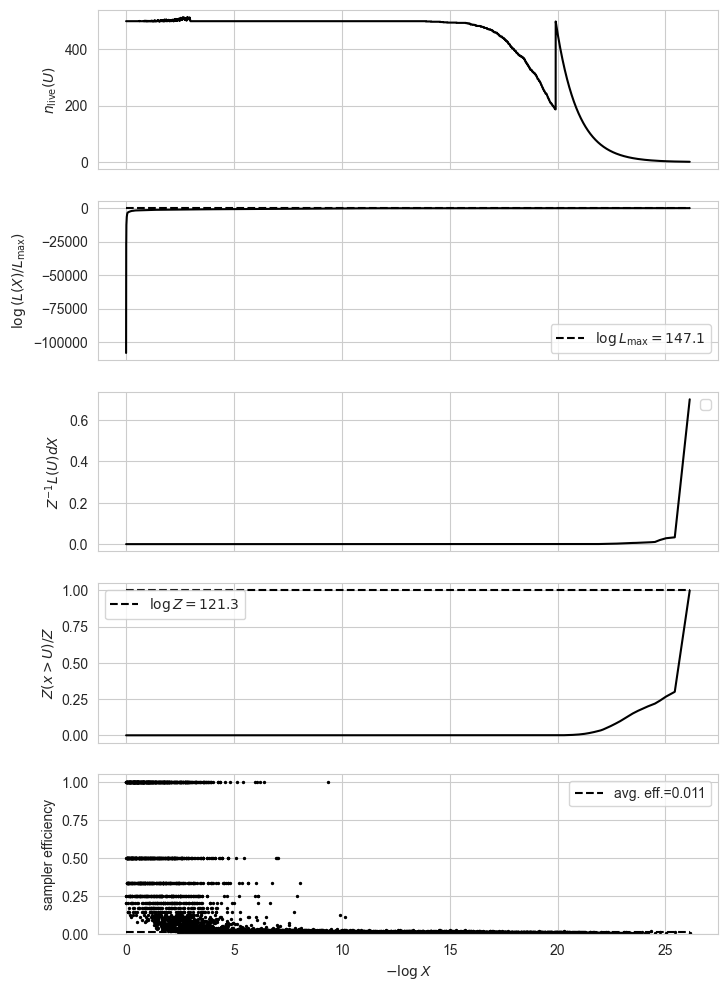

In [57]:
Gpresult5.plot_diagnostics()